In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PORJ_LIB'] = '/home/jhemedinger/anaconda3/envs/goes_env/share/proj'

import pyart
from pyart.core import geographic_to_cartesian_aeqd, Grid
import cartopy.crs as ccrs
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import netCDF4
import itertools
import glob
from scipy import interpolate


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def _nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def interp_lonlat(lon, lat, data, radar_lon, radar_lat, grid_x, grid_y):
    x, y = geographic_to_cartesian_aeqd(lon, lat, radar_lon, radar_lat)

    target_x, target_y = np.meshgrid(grid_x, grid_y)
    points = list(zip(x.flatten(), y.flatten()))
    values = data.flatten()
    interp_data = interpolate.griddata(points, values, (target_x, target_y))
    interp_data = ma.masked_where(np.isnan(interp_data), interp_data)
    interp_data = np.tile(interp_data, (2, 1, 1))
    interp_data = interp_data[np.newaxis, :, :, :]
    return interp_data

In [3]:
def get_grid(filename):
    print('Gridding... ' + filename)
    
    nc = netCDF4.Dataset(filename)
    
    sat_height = nc.variables['goes_imager_projection'].perspective_point_height
    radar_lon = -98.128
    radar_lat = 36.741
    radar_alt = 383.0

    _x = nc.variables['x'] * sat_height
    _y = nc.variables['y'] * sat_height
    _c = nc.variables['CMI_C13'][:] * -1
    data = nc.variables['CMI_C13']
    
    proj_var = nc.variables[data.grid_mapping]
    
    globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.semi_major_axis,
                       semiminor_axis=proj_var.semi_minor_axis)
    
    proj = ccrs.Geostationary(central_longitude=-75,sweep_axis='x',
                              satellite_height=sat_height, globe = globe)
    
    trans = ccrs.PlateCarree(central_longitude=0)
    
    transform_xy = trans.transform_points(proj, _x, _y)
    
    lim = [_nearest(transform_xy[:,0],-103),_nearest(transform_xy[:,0],-92)
            ,_nearest(transform_xy[:,1],42),_nearest(transform_xy[:,1],30)]
    
    
    x = _x[lim[0]:lim[1]]
    y = _y[lim[2]:lim[3]]
    
    c = _c[lim[2]:lim[3],lim[0]:lim[1]]
        
    x_mesh, y_mesh = np.meshgrid(x, y)
    
    lonlat = trans.transform_points(proj, x_mesh, y_mesh)
    lons = lonlat[:, :, 0]
    lats = lonlat[:, :, 1]
    
    interp_c = interp_lonlat(lons, lats, c,
                             radar_lon, radar_lat, grid_x, grid_y) 
    
    _time = {'calendar': 'gregorian','data': np.array([ 0.934]),
             'long_name': 'Time of grid', 'standard_name': 'time',
             'units': str('seconds since ' + nc.time_coverage_end)}
    
#    _fields = {'reflectivity': {'_FillValue': -9999.0, 'data': ma.masked_array(c, mask= False),
#                       'long_name': 'reflectivity',
#                       'standard_name': 'equivalent_reflectivity_factor',
#                       'units': 'dBZ', 'valid_max': c.max(), 'valid_min': c.min()}}
    
    _fields = {'c13': {'_FillValue': -9999.0,
                       'data': interp_c,
                       'long_name': 'channel 13 10.3 microns K',
                       'standard_name': 'c13',
                       'units': 'K', 'valid_max': c.max(),
                       'valid_min': c.min()}}
    
    _metadata = {'Conventions': '', 'comment': '',
                 'history': '', 'institution': '', 'instrument_name': '',
                 'original_container': 'NEXRAD Level II', 'references': '',
                 'source': '', 'title': '', 'vcp_pattern': '', 'version': ''}
    
    _origin_latitude = {'data': ma.array(radar_lat),
                        'long_name': 'Latitude at grid origin',
                        'standard_name': 'latitude',
                        'units': 'degrees_north', 'valid_max': 90.0,
                        'valid_min': -90.0}
    
    _origin_longitude = {'data': ma.array([radar_lon]), 
                         'long_name': 'Longitude at grid origin', 
                         'standard_name': 'longitude', 'units': 'degrees_east', 
                         'valid_max': 180.0, 'valid_min': -180.0}
   
    _origin_altitude = {'data': ma.array(radar_alt), 
                        'long_name': 'Altitude at grid origin', 
                        'standard_name': 'altitude', 'units': 'm'}
    
    _x = {'axis': 'X', 'data': grid_x, 
          'long_name': 'X distance on the projection plane from the origin', 
          'standard_name': 'projection_x_coordinate', 'units': 'm'}
    
    _y = {'axis': 'Y', 'data': grid_y, 
          'long_name': 'Y distance on the projection plane from the origin', 
          'standard_name': 'projection_x_coordinate', 'units': 'm'}
    
    _z = {'axis': 'Z', 'data': np.array([0, mesh_size]),
          'long_name': 'Z distance on the projection plane from the origin',
          'positive': 'up', 'standard_name': 'projection_z_coordinate',
          'units': 'm'}
    
    grid = Grid(time=_time, fields=_fields, metadata=_metadata,
                origin_latitude=_origin_latitude, origin_longitude=_origin_longitude,
                origin_altitude=_origin_altitude, x=_x, y=_y, z=_z)
    
    grid_name = os.path.basename(filename[:-3] + '_grid.nc')
    full_name = os.path.join(output_dir, grid_name)
    pyart.io.write_grid(full_name, grid)

In [4]:
grid_x = np.linspace(-200000,200000,500)
grid_y = grid_x
mesh_size = grid_x[1] - grid_x[0]

# directory where sat files are located
data_dir = '/home/jhemedinger/suli_projects/precipitation-onset/data/data'

# directory where gridded sat files will be saved
output_dir = '/home/jhemedinger/suli_projects/precipitation-onset/grids'

# filelist = sorted(os.listdir(data_dir))
# progress = len(filelist)


# filenames = [build_fn(data_dir, bn) for bn in filelist]
files = glob.glob('/home/jhemedinger/suli_projects/precipitation-onset/data/data/*')
for file in files:
    get_grid(file)
print('Gridding Complete')

Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741710341_e20181741710399_c20181741710471.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741738341_e20181741738399_c20181741738470.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741718341_e20181741718399_c20181741718486.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741759341_e20181741759399_c20181741759471.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741757341_e20181741757399_c20181741757473.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741734341_e20181741734399_c20181741734473.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s

Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741716341_e20181741716399_c20181741716469.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741722341_e20181741722399_c20181741722471.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741701341_e20181741701399_c20181741701470.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741758341_e20181741758399_c20181741758470.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741703341_e20181741703399_c20181741703469.nc
Gridding Complete


In [8]:
import xarray

In [9]:
grid = xarray.open_dataset('/home/jhemedinger/suli_projects/precipitation-onset/grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741700341_e20181741700399_c20181741700473_grid.nc')

In [10]:
grid

<xarray.Dataset>
Dimensions:                     (time: 1, x: 500, y: 500, z: 2)
Coordinates:
  * time                        (time) datetime64[ns] 2018-06-23T17:00:40.834000
  * x                           (x) float64 -2e+05 -1.992e+05 ... 2e+05
  * y                           (y) float64 -2e+05 -1.992e+05 ... 2e+05
  * z                           (z) float64 0.0 801.6
Data variables:
    origin_latitude             (time) float64 ...
    origin_longitude            (time) float64 ...
    origin_altitude             (time) float64 ...
    projection                  int32 ...
    ProjectionCoordinateSystem  int32 ...
    c13                         (time, z, y, x) float64 ...
Attributes:
    Conventions:         
    comment:             
    history:             
    institution:         
    instrument_name:     
    original_container:  NEXRAD Level II
    references:          
    source:              
    title:               
    vcp_pattern:         
    version:             

In [12]:
grid.origin_longitude

<xarray.DataArray 'origin_longitude' (time: 1)>
array([-98.128])
Coordinates:
  * time     (time) datetime64[ns] 2018-06-23T17:00:40.834000
Attributes:
    long_name:      Longitude at grid origin
    units:          degrees_east
    standard_name:  longitude
    valid_max:      180.0
    valid_min:      -180.0

In [2]:
radar = pyart.io.read_grid('/home/jhemedinger/suli_projects/precipitation-onset/grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741700341_e20181741700399_c20181741700473_grid.nc')

In [3]:
radar.fields

{'c13': {'long_name': 'channel 13 10.3 microns K',
  'units': 'K',
  '_FillValue': -9999.0,
  'standard_name': 'c13',
  'valid_max': -230.65536,
  'valid_min': -308.63965,
  'data': masked_array(
    data=[[[-300.03625303, -298.34602675, -271.38931987, ...,
            -277.36765152, -275.33405077, -273.30045002],
           [-296.90617746, -297.8740489 , -296.46681847, ...,
            -276.22467225, -274.28190404, -272.26481215],
           [-299.62616862, -298.71073544, -297.99638548, ...,
            -273.94386479, -273.39799086, -271.38089896],
           ...,
           [-299.52476478, -299.55651154, -299.60667294, ...,
            -297.27736704, -297.09805158, -296.91873612],
           [-299.39265351, -299.44279434, -299.49294113, ...,
            -297.58412966, -297.47518933, -297.29587387],
           [-299.27893631, -299.32907714, -299.37921796, ...,
            -297.80639917, -297.85232708, -297.65572333]],
  
          [[-300.03625303, -298.34602675, -271.38931987, ...,
  

In [4]:
display = pyart.graph.GridMapDisplay(radar)

/home/jhemedinger/dev_pyart/pyart/pyart/graph/gridmapdisplay.py:72: DeprecationWarning: GridMapDisplay will be switching to Cartopy in the next Py-ART release 1.11.0. Basemap is still optional to use in GridMapDisplayBasemap but there will be no support if an error appears.
  DeprecationWarning)


In [13]:
import matplotlib.colors as mcolors

vmin = 198
vmax = 320
lcl = 269.5


colormap = pyart.graph.cm_colorblind.HomeyerRainbow
colors2 = colormap(np.linspace(0, 1, int(((250-vmin)/(vmax-vmin))*1000)))
colors3 = plt.cm.Greys_r(np.linspace(.3, .5, int(((lcl-250)/(vmax-vmin))*1000)))
colors4 = plt.cm.Greys_r(np.linspace(.15, .2, int(((vmax-lcl)/(vmax-vmin))*1000)))
colors = np.vstack((colors4, colors3, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

/home/jhemedinger/anaconda3/envs/precip_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4759: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


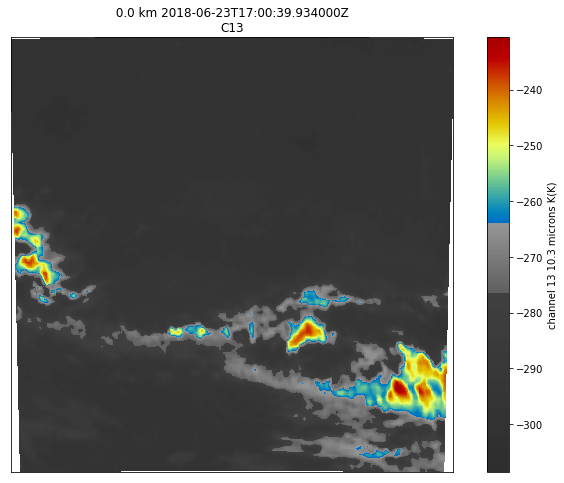

In [6]:
fig = plt.figure(figsize=[12,8])
display.plot_grid('c13', cmap = mymap)
plt.show()

In [7]:
radar.origin_longitude

{'long_name': 'Longitude at grid origin',
 'units': 'degrees_east',
 'standard_name': 'longitude',
 'valid_max': 180.0,
 'valid_min': -180.0,
 'data': masked_array(data=[-98.128],
              mask=False,
        fill_value=1e+20)}

In [ ]:
pyart.graph.cm_colorblind.HomeyerRainbow